In [1]:
import numpy as np
import pandas as pd
import zipfile         
import os
import matplotlib.pyplot as plt
import altair as alt
import re 

#pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", 330)

#### Load in HUD AMI data 

In [2]:
# read in HUD AMI data downloaded for each year from here https://www.huduser.gov/portal/datasets/il.html#2010
path = "/Users/quinnunderriner/Desktop/Work/missing_middle/county_median_data/"
#path = os.getcwd()
df = pd.DataFrame()
for filename in os.listdir(path):
    if filename.startswith("HUD-IL"):
        df_new = pd.read_csv(os.path.join(path, filename))
        df_new["year"] = filename[-8:-4]
        median_col = [x for x in df_new.columns if "median" in x]

        df_new = df_new.rename(columns={median_col[0]:"median"})

        columns = ["State_Alpha","County_Name","Metro_Area_Name","year","median"]
        df_new = df_new[columns]
        df = pd.concat([df,df_new],ignore_index=True)
df = df[df.State_Alpha =="CA"]#filter for california
#df.to_csv("california_hud_AMI_levels_2010-2019.csv")

#### Load in PUMS household Data

got data below from downloading these zips like below, will load in with code if time later to make neater 

for i in range_list:
    print("https://www2.census.gov/programs-surveys/acs/data/pums/"+i+"/1-Year/csv_hca.zip")

In [75]:
#PUMA - County Crosswalk - https://mcdc.missouri.edu/applications/geocorr2018.html.
#note, manually changed all one to many (PUMA->County) matchings to just be "Multiple CA".
#These are the small counties that are just a part of a PUMA and for the purpose of our analysis are combined 
crosswalk_df=pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/PUMA_County_Crosswalk_v2 - PUMA_County_Crosswalk.csv", delimiter=",")

In [4]:
def read_in_PUMS(hpums_df,col_names):
    variable_types = {"NP":"int64","NOC":"float","BDSP":"float","RMSP":"str","MV":"float","WGTP":"float"}

    columns = ["SERIALNO","NP","R65","NRC","PUMA","RT","BDSP","BLD","RNTP","MRGP","SMP", "TYPE",
               "CONP","TEN","VACS","VALP","GRPIP","GRNTP","SMOCP","OCPIP","HINCP","MV","WGTP","NOC", "MULTG", 'YBL']


    hpums_df.rename(columns={"RT":"record_type",
                         "TYPE":"type",
                         "BLD":"units_in_structure",
                         "BDSP":"number_bedrooms",
                         "RNTP":"monthly_rent",
                         "MRGP":"first_mortgage",
                         "SMP":"second_mortgage",
                         "CONP":"condo_fee",
                         "TEN":"tenure",
                         "VACS":"vacancy_status",
                         "VALP":"property_value",
                         "GRPIP":"gross_rent_pct_of_income",
                         "GRNTP":"gross_rent",
                         "SMOCP":"select_owner_cost",
                         "OCPIP":"select_owner_cost_pct_of_income",
                         "HINCP":"hh_income",
                         "NP":"ppl_in_hh",
                         "R65":"ppl_over_65",
                         "NRC":"num_relate_chldrn",
                         "NOC":"num_own_chldrn",
                         "MULTG":"multi_gen_hh",
                         "WGTP":"weight",
                         "YBL": "year_built",
                         "MV":"moved_in"}, inplace=True)
    hpums_df.drop(hpums_df[hpums_df.type != 1].index, inplace=True)
    
    return hpums_df

Markdown cell because want to be rerunning file and easier to just load in output of below 
from a csv then wait for the below to run to run everytime. But this code takes the 2010-2019
PUMS household data, makes a year column, and then concat its together 

for filename in os.listdir(path_csv):
    df_new1 = pd.read_csv(os.path.join(path_csv, filename))
    df_new1= read_in_PUMS(df_new1,col_names)
    df_new1["year"] = filename[-8:-4] 
    hca = pd.concat([hca,df_new1],ignore_index=True)
pums_ca = hca.ST["6"]#added retroactively 

In [5]:
#load in output of above from CSV 
pums_ca = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/2010-2019_ca_household_survey.csv")
pums_sub_cols = ["County",'year',"hh_income","ppl_in_hh",'PUMA']#Took more cols just in case from big dataset above, but this is all we need for this calc 
pums_ca = pums_ca[pums_sub_cols]

/Users/quinnunderriner/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11,12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Do PUMA to County Crosswalk

Note: for years 2010 and 2011 the 2010 PUMA defintions were still being used; it was not until 2012 that the
    new definitions came into effect. Therefore need to map the 2010-2011 and 2012-2019 groups seperately. 

In [6]:
def gimmie_county(x):
    return x[0:x.find('County')]

def bring_in_crosswalk(df):
    crosswalk_df2010 = pd.read_excel("PUMA2000_PUMA2010_crosswalk.xls") # https://usa.ipums.org/usa/volii/pumas10.shtml#crosswalk
    crosswalk_df2010 = crosswalk_df2010[crosswalk_df2010.State10_Name =="California"]
    crosswalk_df2010 = crosswalk_df2010[["PUMA00","PUMA10","PUMA10_Name"]] #filter for datasetes we want 
    
    df_2010 = df[df.year.isin([2010,2011])] 
    
    df_2010 = df_2010.drop(columns={"County"}) #drop county col, was missing for these years, will re add below 
    
    pums_ca_2010 = df_2010.merge(crosswalk_df2010, how="left",left_on="PUMA",right_on="PUMA00")
    
    pums_ca_2010["County"] = pums_ca_2010.PUMA10_Name.apply(lambda x: gimmie_county(x))
    
    pums_ca_2010 = pums_ca_2010.drop(columns={"PUMA","PUMA00"})
    pums_ca_2010 = pums_ca_2010.rename(columns={"PUMA10":"PUMA"})#make new PUMA col the definitive PUMA col 
    
    pums_ca_2010 = pums_ca_2010[["year","hh_income","ppl_in_hh","County","PUMA"]]#keep only cols we want so we can concat 
    
    crosswalk_df2012 = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/PUMA_County_Crosswalk_v2 - PUMA_County_Crosswalk.csv", delimiter=",")

    df_2012 = df[~df.year.isin([2010,2011])]

    puma_county_df_2012 = df.merge(crosswalk_df2012, how='left', on="PUMA")
    puma_county_df_2012['County'] = puma_county_df_2012['county1'].str.replace(r' CA', '')
    puma_county_df_2012.drop('county1', axis=1, inplace=True)
    
    puma_county_df_2012 = puma_county_df_2012[["year","hh_income","ppl_in_hh","County","PUMA"]]#keep only cols we want so we can concat 

    puma_county_df = pd.concat([pums_ca_2010, puma_county_df_2012], ignore_index=True) #concat both datasets back together now that they have the same columns 
    
    return puma_county_df

In [7]:
pums_ca = bring_in_crosswalk(pums_ca) #call function 

In [8]:
pums_ca = pums_ca.dropna() # we lose ~300k records for having null values 
# we lose another 7896 by getting rid of entries with bad types, acceptable error in a dataset this big 
pums_ca = pums_ca[pd.to_numeric(pums_ca['hh_income'], errors='coerce').notnull()]
pums_ca.hh_income = pums_ca.hh_income.astype(float) #convert to float so we can do calculations 

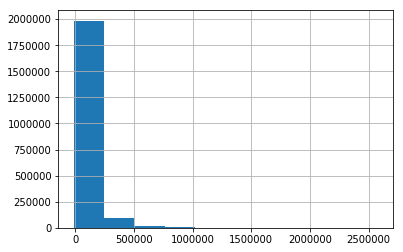

In [9]:
import matplotlib.pyplot as plt
#check for outliers in hh income 
pums_ca.hh_income.hist()

In [10]:
#in this dataset negative income doenst really make sense, so I'll drop those rows.
#Strange to see renter with 2.5 million income, but certainly not impossible in sf so can't
#assume data error. 
pums_ca.hh_income.describe()

count   2104477.00
mean      90445.28
std       98202.15
min      -15700.00
25%       30700.00
50%       63530.00
75%      114500.00
max     2580000.00
Name: hh_income, dtype: float64

In [11]:
pums_ca = pums_ca[pums_ca['hh_income'] >=0] #drop negative hh income  

Need to adjust median income figure for family size 

"Calculation of income limits for other family sizes is straight-forward. The 1-person family income limit is 70% of the 4-person income limit. The 2-person family income limit is 80% of the 4-person income limit, the 3-person family income limit is 90% of the 4-person income limit, the 5-person income limit is 108% of the 4-person income limit, the 6-person family income limit is 116% of the 4-person income limit, the 7-person family income limit is 124% of the 4-person income limit, and the 8-person family income limit is 132% of the 4-person income limit. For family sizes larger than 8 persons, the income limit can be calculated by adding an additional eight (8) percent per person to the next lower limit. For example a 9-person family income limit is 140% (132% + 8%), and so on. The resulting low-income limit calculation for other family sizes are then rounded up to the nearest $50 to produce the Final VLIL."

https://www.huduser.gov/portal/datasets/il/il2020/2020IlCalc.odn


In [12]:
#need to have household adjustments for up to size 20 
pums_ca.ppl_in_hh.value_counts()

2     666919
1     505353
3     339571
4     304312
5     157804
6      70477
7      29662
8      14229
9       6949
10      3698
11      1986
12      1334
13       404
14       254
15       129
16        61
20        48
17        32
19        15
18        13
Name: ppl_in_hh, dtype: int64

In [13]:
pums_ca.County = pums_ca.County.str.rstrip()#strip trailing white space 
pums_ca = pums_ca.replace({
    'County':{'Monterey (South & East) & San Benito Countie':"Multiple",
            'Nevada & Sierra Countie':"Multiple","Sutter & Yuba Counties--Yuba Cit":"Multiple",
            "Del Norte, Lassen, Modoc, Plumas & Siskiyou Countie":"Multiple",
            "Alpine, Amador, Calaveras, Inyo, Mariposa, Mono & Tuolumne Countie":"Multiple",
             'Colusa, Glenn, Tehama & Trinity Countie':"Multiple",
             "Lake & Mendocino Countie":"Multiple"}})#the 2010-2011 data did the one to many PUMA to County mapping, I'm just manually setting these to the Multiple category

There is going to be a discrepency between the HUD data, which has every county in California, 
with the PUMS data, which has only the those that have a least one PUMA soley mapped to it. 
We need then to map the small counties in HUD with a one PUMA to many counties matching to the 
"multiple counties" category that we have in the PUMS data. 

In [14]:
#make sets of both county lists and look at the set difference to see what needs the "multiple" mapping 
pums_ca.County = pums_ca.County + " County"#make naming conventions align with HUD data so can merge

pums_set = set(pums_ca.County)
hud_set = set(df["County_Name"])#now want to map everything not present in this data to the multiple category 
small_counties = hud_set.difference(pums_set)

In [15]:
def small_multiples(x):
    """
    This function returns "Multiple Counties" if county name is in the list of small counties, otherwise
    keeps same value 
    """
    if x in small_counties:
        return "Multiple County"
    else:
        return x 
df["County_Name"] = df["County_Name"].apply(lambda x: small_multiples(x))


In [16]:
df.head()

,State_Alpha,County_Name,Metro_Area_Name,year,median
186,CA,Alameda County,"Oakland-Fremont, CA HUD Metro FMR Area",2017,97400
187,CA,Multiple County,"Alpine County, CA",2017,74200
188,CA,Multiple County,"Amador County, CA",2017,70900
189,CA,Butte County,"Chico, CA MSA",2017,62600
190,CA,Multiple County,"Calaveras County, CA",2017,69200


In [17]:
df["County_Name"] = df["County_Name"].apply(lambda x: small_multiples(x))


In [18]:
df["County_Name"].unique()

array(['Alameda County', 'Multiple County', 'Butte County',
       'Contra Costa County', 'El Dorado County', 'Fresno County',
       'Humboldt County', 'Imperial County', 'Kern County',
       'Kings County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Merced County', 'Monterey County', 'Napa County',
       'Orange County', 'Placer County', 'Riverside County',
       'Sacramento County', 'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Solano County', 'Sonoma County',
       'Stanislaus County', 'Tulare County', 'Ventura County',
       'Yolo County'], dtype=object)

In [19]:
pums_ca["key"] = pums_ca["County"] + pums_ca["year"].astype(str) #make keys to match on 
df["key"] = df["County_Name"] + df["year"].astype(str) #make keys to match on 

In [20]:
#need to create range of values for each county 
df["80%_AMI"] = df["median"] * 0.8
df["120%_AMI"] = df["median"] * 1.2

In [21]:
df.County_Name.unique()

array(['Alameda County', 'Multiple County', 'Butte County',
       'Contra Costa County', 'El Dorado County', 'Fresno County',
       'Humboldt County', 'Imperial County', 'Kern County',
       'Kings County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Merced County', 'Monterey County', 'Napa County',
       'Orange County', 'Placer County', 'Riverside County',
       'Sacramento County', 'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Solano County', 'Sonoma County',
       'Stanislaus County', 'Tulare County', 'Ventura County',
       'Yolo County'], dtype=object)

In [22]:
pums_ca.County.unique()

array(['Butte County', 'Placer County', 'Multiple County',
       'Los Angeles County', 'Riverside County', 'Yolo County',
       'Contra Costa County', 'San Mateo County', 'Sacramento County',
       'San Joaquin County', 'San Bernardino County', 'Orange County',
       'Kern County', 'Tulare County', 'Santa Barbara County',
       'Ventura County', 'Fresno County', 'Monterey County',
       'El Dorado County', 'Merced County', 'Santa Clara County',
       'Alameda County', 'Stanislaus County', 'Solano County',
       'San Luis Obispo County', 'Humboldt County',
       'San Francisco County', 'San Diego County', 'Santa Cruz County',
       'Shasta County', 'Sonoma County', 'Kings County', 'Marin County',
       'Imperial County', 'Napa County', 'Madera County'], dtype=object)

In [23]:
#merge data 
df_merged = pums_ca.merge(df,on="key",how="left")
#df_merged.to_csv("HUD_PUMS_merged_data_CA.csv")

In [24]:
pums_ca.head()

,year,hh_income,ppl_in_hh,County,PUMA,key
0,2011,74000.00,2,Butte County,702,Butte County2011
1,2011,74000.00,2,Placer County,6103,Placer County2011
2,2011,74000.00,2,Multiple County,10100,Multiple County2011
3,2011,74000.00,2,Multiple County,1500,Multiple County2011
4,2011,29300.00,1,Los Angeles County,3740,Los Angeles County2011


In [25]:
pums_ca["key"][0]

'Butte County2011'

STATE OF AFFAIRS EOD

as noted below, make sure both have the Multple counties thing populating correclty, somethign is wrong with the 
PUMS multiple key

with HUD DF NEED TO AVERAGE ACROSS THE MULTIPLE MULTIPLE COUNTIES MAPPINGS IN DF, AMI Bands, prior to merge. 

then:

 1. graph for all of california 
 2. graph for top 10 MSAs
 3. graph for remaining counties 



In [26]:
set(df.key).difference(set(pums_ca.key))

set()

In [27]:
set(df.key).union(set(pums_ca.key))

{'Alameda County2010',
 'Alameda County2011',
 'Alameda County2012',
 'Alameda County2013',
 'Alameda County2014',
 'Alameda County2015',
 'Alameda County2016',
 'Alameda County2017',
 'Alameda County2018',
 'Alameda County2019',
 'Butte County2010',
 'Butte County2011',
 'Butte County2012',
 'Butte County2013',
 'Butte County2014',
 'Butte County2015',
 'Butte County2016',
 'Butte County2017',
 'Butte County2018',
 'Butte County2019',
 'Contra Costa County2010',
 'Contra Costa County2011',
 'Contra Costa County2012',
 'Contra Costa County2013',
 'Contra Costa County2014',
 'Contra Costa County2015',
 'Contra Costa County2016',
 'Contra Costa County2017',
 'Contra Costa County2018',
 'Contra Costa County2019',
 'El Dorado County2010',
 'El Dorado County2011',
 'El Dorado County2012',
 'El Dorado County2013',
 'El Dorado County2014',
 'El Dorado County2015',
 'El Dorado County2016',
 'El Dorado County2017',
 'El Dorado County2018',
 'El Dorado County2019',
 'Fresno County2010',
 'Fresno

In [28]:
pums_ca_count = pums_ca.groupby(["County","year"]).count().reset_index()

In [29]:
pums_ca_count.head()

,County,year,hh_income,ppl_in_hh,PUMA,key
0,Alameda County,2010,11893,11893,11893,11893
1,Alameda County,2011,11996,11996,11996,11996
2,Alameda County,2012,5825,5825,5825,5825
3,Alameda County,2013,6032,6032,6032,6032
4,Alameda County,2014,6056,6056,6056,6056


In [30]:
#confirm, we have values for all 10 years for all counties 
pums_ca_count.County.value_counts()

Riverside County          10
Yolo County               10
Santa Cruz County         10
Kern County               10
Marin County              10
Contra Costa County       10
Tulare County             10
Shasta County             10
Ventura County            10
San Bernardino County     10
Los Angeles County        10
Imperial County           10
Butte County              10
Madera County             10
San Mateo County          10
Santa Barbara County      10
Multiple County           10
Stanislaus County         10
Orange County             10
Sacramento County         10
Fresno County             10
El Dorado County          10
Sonoma County             10
Kings County              10
Monterey County           10
San Luis Obispo County    10
Santa Clara County        10
Placer County             10
San Francisco County      10
Humboldt County           10
Napa County               10
San Diego County          10
San Joaquin County        10
Merced County             10
Alameda County

In [31]:
df_merged["80%_AMI"].value_counts()

50400.00    204751
51200.00    177118
58480.00     68704
52000.00     64868
50000.00     59172
             ...  
44320.00       420
34400.00       401
44160.00       400
36640.00       396
37520.00       383
Name: 80%_AMI, Length: 308, dtype: int64

In [32]:
# do some column clean up 
df_merged = df_merged.drop(columns={"year_x"})
df_merged = df_merged.rename(columns={"year_y":"year"})

In [33]:
#create AMI percentages from median number 
df_merged["80%_AMI"] = df_merged["median"] * 0.8
df_merged["120%_AMI"] = df_merged["median"] * 1.2

In [34]:
family_size_dict = {1:.7,
                   2:.8,
                   3:.9,
                   4:1,
                    5:1.08,
                    6:1.16,
                    7:1.24,
                    8:1.32,
                   9:1.40,
                   10:1.48,
                   11:1.56,
                   12:1.64,
                   13:1.72,
                   14:1.80,
                   15:1.88,
                   16:1.96,
                   17:2.04,
                   18:2.12,
                   19:2.20,
                   20:2.28}
#make new column of the AMI multiplier based on each households family size 
df_merged["family_size_multiplier"] = df_merged["ppl_in_hh"].map(family_size_dict)

In [35]:
#adjust ami bands for each household based on household size 
df_merged["80%_AMI_adjusted"] = df_merged["80%_AMI"] * df_merged["family_size_multiplier"]
df_merged["120%_AMI_adjusted"] = df_merged["120%_AMI"] * df_merged["family_size_multiplier"]

In [36]:
#want to label households in dataset that are middle income 
df_merged['middle_income_HH'] = np.where((df_merged["hh_income"] >= df_merged["80%_AMI_adjusted"])&(df_merged["hh_income"] <= df_merged["120%_AMI_adjusted"]), 1, 0)

In [37]:
middle_income = df_merged[df_merged['middle_income_HH'] ==1]

In [38]:
# 17.6 percent of households in our dataset fall into this middle income category
len(middle_income)/len(df_merged) 

0.17625170997073827

In [39]:
#here i want to sum middle income houses for each year and county combo and then also get a total count for each 
#year and county combo, and make a small data frame with just this information. 
#then can calculate percentage of Middle income renters in each year and county through simple divison 
mid_income_count = df_merged.groupby(["year","County_Name"]).sum().reset_index()[["year","County_Name","middle_income_HH"]]
total_income_count = df_merged.groupby(["year","County_Name"]).count().reset_index()[["year","County_Name","middle_income_HH"]]
mid_income_count_percentage = mid_income_count.merge(total_income_count,on=["year","County_Name"])
mid_income_count_percentage = mid_income_count_percentage.rename(columns={"middle_income_HH_x":"middle_income_HH","middle_income_HH_y":"total"})
mid_income_count_percentage["Middle Income Renter Percentage"] = mid_income_count_percentage["middle_income_HH"] /mid_income_count_percentage["total"]

In [40]:
mid_income_count_percentage["Middle Income Renter Percentage"].describe()

count   360.00
mean      0.18
std       0.01
min       0.13
25%       0.17
50%       0.18
75%       0.18
max       0.24
Name: Middle Income Renter Percentage, dtype: float64

In [48]:
mid_income_count_percentage.

,year,County_Name,middle_income_HH,total,Middle Income Renter Percentage
0,2010,Alameda County,2140,11893,0.18
1,2010,Butte County,690,3670,0.19
2,2010,Contra Costa County,2512,12623,0.20
3,2010,El Dorado County,529,2702,0.20
4,2010,Fresno County,2580,14928,0.17
...,...,...,...,...,...
355,2019,Sonoma County,382,1947,0.20
356,2019,Stanislaus County,312,1644,0.19
357,2019,Tulare County,175,1193,0.15
358,2019,Ventura County,595,3013,0.20


In [41]:
mid_income_count_percentage.County_Name.unique()

array(['Alameda County', 'Butte County', 'Contra Costa County',
       'El Dorado County', 'Fresno County', 'Humboldt County',
       'Imperial County', 'Kern County', 'Kings County',
       'Los Angeles County', 'Madera County', 'Marin County',
       'Merced County', 'Monterey County', 'Multiple County',
       'Napa County', 'Orange County', 'Placer County',
       'Riverside County', 'Sacramento County', 'San Bernardino County',
       'San Diego County', 'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Solano County', 'Sonoma County',
       'Stanislaus County', 'Tulare County', 'Ventura County',
       'Yolo County'], dtype=object)

### Average Across California

In [60]:
cali_average = mid_income_count_percentage.groupby("year").mean().reset_index()

In [61]:
alt.Chart(cali_average).mark_line().encode(
    x='year',
    y='Middle Income Renter Percentage'
    
)

alt.Chart(...)

### San Francisco and Los Angeles 

In [52]:
mid_income_count_percentage.County_Name.unique()

array(['Alameda County', 'Butte County', 'Contra Costa County',
       'El Dorado County', 'Fresno County', 'Humboldt County',
       'Imperial County', 'Kern County', 'Kings County',
       'Los Angeles County', 'Madera County', 'Marin County',
       'Merced County', 'Monterey County', 'Multiple County',
       'Napa County', 'Orange County', 'Placer County',
       'Riverside County', 'Sacramento County', 'San Bernardino County',
       'San Diego County', 'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Solano County', 'Sonoma County',
       'Stanislaus County', 'Tulare County', 'Ventura County',
       'Yolo County'], dtype=object)

In [54]:
la_mid_income = mid_income_count_percentage[mid_income_count_percentage.County_Name == "Los Angeles County"]
la_mid_income.groupby("year").mean().reset_index()

In [72]:
alt.Chart(la_mid_income).mark_line().encode(
    x='year',
    y='Middle Income Renter Percentage'
    
)

alt.Chart(...)

In [57]:
sf_mid_income = mid_income_count_percentage[mid_income_count_percentage.County_Name == "San Francisco County"]
sf_mid_income.groupby("year").mean().reset_index()

,year,middle_income_HH,total,Middle Income Renter Percentage
0,2010,843,5113,0.16
1,2011,855,5153,0.17
2,2012,498,3158,0.16
3,2013,528,3306,0.16
4,2014,509,3296,0.15
5,2015,504,3304,0.15
6,2016,491,3351,0.15
7,2017,497,3370,0.15
8,2018,456,3302,0.14
9,2019,537,3469,0.15


In [58]:
alt.Chart(sf_mid_income).mark_line().encode(
    x='year',
    y='Middle Income Renter Percentage'
    
)

alt.Chart(...)

### Bay Area

In [42]:
bay_area_counties = ["Alameda County",
"Contra Costa County",
"Marin County",
"Napa County",
"San Francisco County",
"San Mateo County",
"Santa Clara County",
"Solano County",
"Sonoma County"]
bay_area = mid_income_count_percentage[mid_income_count_percentage.County_Name.isin(bay_area_counties)]

#df = df[df['CSA'].isin(csa_filter)]

In [43]:
bay_area["key"] = bay_area["year"].astype(str) + bay_area["County_Name"]

/Users/quinnunderriner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
alt.Chart(bay_area).mark_line().encode(
    x='year',
    y='Middle Income Renter Percentage',
    color="County_Name"
)

alt.Chart(...)

In [ ]:
### All counties 

In [62]:
alt.Chart(mid_income_count_percentage).mark_line().encode(
    x='year',
    y='Middle Income Renter Percentage',
    color="County_Name"
)

alt.Chart(...)

### Top 10 MSAs

In [114]:
#pull in mapping of MSAs to Counties from here https://catalog.data.gov/dataset/california-metropolitan-statistical-areas-msa-and-metropolitan-divisions-md-163d2/resource/580630a6-9db5-4aaf-b331-3a4b3d476c09
#get ranking of MSAs here: https://docs.fcc.gov/public/attachments/DOC-240702A2.pdf
#
msa = pd.read_csv("msa.csv")
msa = msa[["MSA_NAME","COUNTIES"]]
top_10_msa = ['Riverside-San Bernardino-Ontario','San Jose-Sunnyvale-Santa Clara',
              'San Francisco-Redwood City-South San Francisco','Oakland-Hayward-Berkeley',
              'Los Angeles-Long Beach-Glendale','Anaheim-Santa Ana-Irvine','San Diego-Carlsbad',
               'Sacramento--Roseville--Arden-Arcade','Fresno','Oxnard-Thousand Oaks-Ventura']
msa = msa[msa.MSA_NAME.isin(top_10_msa)]
#need to expand mapping 
msa = msa.drop('COUNTIES', axis=1).join(
  msa['COUNTIES'].str.split(',', expand=True).stack()
    .reset_index(level=1,drop=True).rename('COUNTIES'))
msa['COUNTIES'] = msa['COUNTIES'] + " County" 
msa = msa.rename(columns={"COUNTIES":"County_Name"})#rename for clean merge 

In [115]:
msa_merged = msa.merge(mid_income_count_percentage,on="County_Name",how="left")
msa_merged = msa_merged.groupby(["MSA_NAME","year"]).mean().reset_index()

In [116]:
alt.Chart(msa_merged).mark_line().encode(
    x='year',
    y='Middle Income Renter Percentage',
    color="MSA_NAME"
)

alt.Chart(...)

In [45]:
#all counties are present in both 
len(df.County_Name.unique()) - len(pums_ca.County.unique())

0

In [46]:
#all counties are present in both 
set(df.County_Name.unique()).difference(set(pums_ca.County.unique()))

set()